# Build an SQL agent with LangGraph and Mistral Medium 3 by using watsonx.ai

**Author**: Anna Gutowska

In this tutorial, you will build an [AI agent](https://www.ibm.com/think/topics/ai-agents) that can execute and generate Python and [SQL](https://www.ibm.com/think/topics/structured-query-language) queries for your custom SQLite database. Your agent will be built from scratch by using [LangGraph](https://www.ibm.com/think/topics/langgraph) and the Mistral Medium 3 [large language model (LLM)](https://www.ibm.com/think/topics/large-language-models). This LLM is optimized for professional use cases such as coding and multimodal understanding, thus making it an excellent choice for this task.<sup>1</sup> We will also detect and block harmful messages by using the Granite Guardian model.

## What is LangGraph? 

[LangGraph](https://www.ibm.com/think/topics/langgraph), created by [LangChain](https://www.ibm.com/think/topics/langchain), is an [open source](https://www.ibm.com/think/topics/open-source) [AI agent framework](https://www.ibm.com/think/insights/top-ai-agent-frameworks) designed to build, deploy and manage complex generative [AI agent workflows](https://www.ibm.com/think/topics/agentic-workflows). It provides a set of [tools](https://www.ibm.com/think/topics/tool-calling) and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various [components](https://www.ibm.com/think/topics/components-of-ai-agents) of an AI agent workflow, including those found in multi-agent systems.


## Prerequisites

1. You need an [IBM Cloud® account](https://cloud.ibm.com/registration) to create a watsonx.ai® project.

2. Several Python versions can work for this tutorial. At the time of publishing, we recommend [downloading](https://www.python.org/downloads/) Python 3.13, the latest version.

## Steps

### Step 1. Set up your environment

While you can choose from several tools, this tutorial walks you through how to set up an IBM account to use a Jupyter Notebook. 

1. Log in to [watsonx.ai](https://dataplatform.cloud.ibm.com/registration/stepone?context=wx&apps=all) by using your IBM Cloud® account.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas?topic=projects-creating-project).

	You can get your project ID from within your project. Click the **Manage** tab. Then, copy the project ID from the **Details** section of the **General** page. You need this ID for this tutorial.

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas?topic=editor-creating-managing-notebooks).

	This step opens a Jupyter Notebook environment where you can copy the code from this tutorial.  Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. This tutorial is also available on [GitHub](https://github.com/IBM/ibmdotcom-tutorials).


### Step 2. Set up a watsonx.ai Runtime instance and API key.

1. Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) service instance (select your appropriate region and choose the Lite plan, which is a free instance).

2. Generate an application programming interface [(API) key](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html). 

3. Associate the watsonx.ai Runtime service instance with the project that you created in [watsonx.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html). 

### Step 3. Install and import relevant libraries and set up your credentials

We need a few libraries and modules for this tutorial. Make sure to import the following ones and if they're not installed, a quick pip installation resolves the problem. 

In [ ]:
#installations
%pip install -qU ibm-watsonx-ai \
    langchain-ibm \
    langgraph \
    langchain_experimental \
    tavily-python \
    langchain-community

Restart your terminal and import the following packages.

In [ ]:
# imports
import sqlite3
import getpass

from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models.moderations import Guardian
from IPython.display import Image, display
from langchain import hub  
from langchain_ibm import ChatWatsonx
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonREPLTool
from sqlalchemy import create_engine
from typing_extensions import TypedDict
from typing import Annotated

To set our credentials, we will need the `WATSONX_APIKEY` and `WATSONX_PROJECT_ID` that you generated in Step 1. We will also set the `URL` to serve as the API endpoint.

In [ ]:
WATSONX_APIKEY = getpass.getpass("Please enter your watsonx.ai Runtime API key (hit enter): ")

WATSONX_PROJECT_ID = getpass.getpass("Please enter your project ID (hit enter): ")

URL = "https://us-south.ml.cloud.ibm.com"

Before we can initialize our LLM, we can use the `Credentials` class to encapsulate our passed API credentials.

In [ ]:
credentials = Credentials(url=URL, api_key=WATSONX_APIKEY)

### Step 4. Instantiate the chat model

To be able to interact with all resources available in watsonx.ai Runtime, you need to set up an `APIClient`. Here, we pass in our credentials and `WATSONX_PROJECT_ID`.

In [ ]:
client = APIClient(credentials=credentials, project_id=WATSONX_PROJECT_ID)

For this tutorial, we will be using the ChatWatsonx wrapper to set up our chat model. This wrapper simplifies the integration of tool calling and chaining. We encourage you to use the API references in the ChatWatsonx [official docs](https://python.langchain.com/docs/integrations/chat/ibm_watsonx/#tool-calling) for further information. We can pass in our `model_id` for Mistral Medium 3 and our client as parameters. 

Note, if you use a different API provider, you will need to change the wrapper accordingly. For example, to use the OpenAI API to access models such as GPT-4, you will need an `openai_api_key` as well as the `ChatOpenAI` wrapper. 

In [ ]:
model_id = "mistralai/mistral-medium-2505" 

llm = ChatWatsonx(model_id=model_id, watsonx_client=client)

### Step 5. Set up the SQLite database

In this tutorial, your agent will use its available tools to interact with an SQLite database. If you already have a dataset stored in a relational database management system such as PostgreSQL or SQLite, you can skip this step. Otherwise, run the following cell to set the `sql_script` variable equal to a script that generates a database containing synthetic car dealership sales data. This database will contain several tables for storing individual dealership, sales and vehicle data.

In [ ]:
sql_script = """
DROP TABLE IF EXISTS [Dealerships];

DROP TABLE IF EXISTS [Cars];

DROP TABLE IF EXISTS [Sales];

CREATE TABLE [Dealerships] (
    [id] INTEGER PRIMARY KEY,
    [name] TEXT NOT NULL,
    [location] TEXT NOT NULL
);

CREATE TABLE [Cars] (
    [id] INTEGER PRIMARY KEY,
    [make] TEXT NOT NULL,
    [model] TEXT NOT NULL,
    [year] INTEGER NOT NULL,
    [color] TEXT NOT NULL
);

CREATE TABLE [Sales] (
    [id] INTEGER PRIMARY KEY,
    [car_id] INTEGER NOT NULL,
    [dealership_id] INTEGER NOT NULL,
    [sale_date] DATE NOT NULL,
    [sale_price] REAL NOT NULL,
    FOREIGN KEY ([car_id]) REFERENCES [Cars] ([id]),
    FOREIGN KEY ([dealership_id]) REFERENCES [Dealerships] ([id])
);


INSERT INTO [Dealerships] ([id], [name], [location]) VALUES
    (1, 'Dealership A', 'New York'),
    (2, 'Dealership B', 'Los Angeles'),
    (3, 'Dealership C', 'Chicago'),
    (4, 'Dealership D', 'Houston'),
    (5, 'Dealership E', 'Phoenix'),
    (6, 'Dealership F', 'Philadelphia'),
    (7, 'Dealership G', 'San Antonio'),
    (8, 'Dealership H', 'San Diego'),
    (9, 'Dealership I', 'Dallas'),
    (10, 'Dealership J', 'San Jose');

INSERT INTO [Cars] ([id], [make], [model], [year], [color]) VALUES
    (1, 'Toyota', 'Camry', 2020, 'Blue'),
    (2, 'Honda', 'Civic', 2019, 'Red'),
    (3, 'Ford', 'Mustang', 2021, 'Black'),
    (4, 'Chevrolet', 'Silverado', 2018, 'White'),
    (5, 'Nissan', 'Altima', 2020, 'Gray'),
    (6, 'Kia', 'Optima', 2020, 'Silver'),
    (7, 'Hyundai', 'Elantra', 2019, 'Black'),
    (8, 'Volkswagen', 'Golf', 2021, 'Red'),
    (9, 'BMW', '3 Series', 2018, 'White'),
    (10, 'Mercedes-Benz', 'C-Class', 2020, 'Gray'),
    (11, 'Audi', 'A4', 2019, 'Blue'),
    (12, 'Lexus', 'ES', 2021, 'Black'),
    (13, 'Toyota', 'Corolla', 2018, 'White'),
    (14, 'Honda', 'Accord', 2020, 'Gray'),
    (15, 'Ford', 'Fusion', 2019, 'Red');

INSERT INTO [Sales] ([id], [car_id], [dealership_id], [sale_date], [sale_price]) VALUES
    (1, 1, 1, '2022-01-01', 25000.0),
    (2, 2, 2, '2022-02-01', 20000.0),
    (3, 3, 3, '2022-03-01', 30000.0),
    (4, 4, 1, '2022-04-01', 40000.0),
    (5, 5, 2, '2022-05-01', 28000.0),
    (6, 6, 4, '2022-06-01', 22000.0),
    (7, 7, 5, '2022-07-01', 20000.0),
    (8, 8, 6, '2022-08-01', 28000.0),
    (9, 9, 7, '2022-09-01', 35000.0),
    (10, 10, 8, '2022-10-01', 32000.0),
    (11, 11, 9, '2022-11-01', 30000.0),
    (12, 12, 10, '2022-12-01', 38000.0),
    (13, 13, 1, '2023-01-01', 25000.0),
    (14, 14, 2, '2023-02-01', 28000.0),
    (15, 15, 3, '2023-03-01', 22000.0);
    
"""

In order to run this script and create the local SQLite database, we need to set up a database `Connection` object. By passing the ":memory:" path name, we can connect to a transient in-memory database. 

In [ ]:
connection = sqlite3.connect(":memory:")

Next, we can use the `executescript` method to create a database cursor and to run our SQL script. This `Cursor` object allows us to run such scripts. 

In [ ]:
connection.executescript(sql_script)

Finally, run the following command to create a `SQLAlechemy` Engine instance with a connection to the database file in your working directory. The file should have the same name as your Jupyter Notebook with a database file extension. We can keep the URL empty so that the connection is made to the SQLite local database. We can provide our `Connection` object in the `creator` parameter. This parameter is responsible for creating the connection to the database. 

In [ ]:
engine = create_engine(
    "sqlite://",
    creator=lambda: connection
)

If you prefer to use an alternative database for this tutorial that is not stored locally, simply replace the empty path with "sqlite:///Chinook.db" to access a sample digital media store database.  

### Step 6. Set up the tools

This tutorial uses the LangChain pre-built `SQLDatabaseToolkit`. The toolkit requires a `SQLDatabase` object, which takes the `SQLAlchemy` Engine as a parameter, and the LLM of choice. Once we instantiate the toolkit, we can then retrieve its tools. Let's print the tools to see more details.

In [ ]:
db = SQLDatabase(engine)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x31b7d5c10>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x31b7d5c10>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x31b7d5c10>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

We can see there are 4 tools available as part of the toolkit. Each tool serves its own purpose, as seen by the tool descriptions. The tools are built to list the databases, run queries, return table schemas and verify SQL queries before running them.

To equip our agent with the ability to generate and execute Python code, we can leverage LangChain's `PythonREPLTool` class. Using the `@tool` operator, we can run the tool and handle any failed code executions. This tool can be appended to the list of SQL tools. 

In [ ]:
code_tool = PythonREPLTool()

@tool
def python_repl(code: str) -> str:
    """Use this to execute python code."""
    try:
        result = code_tool.run(code)
        print(result)
    except BaseException as e:
        return f"Failed to execute. Error :  {e!r}"
    else:
        return f"Result of code execution {result}"
    
tools.append(python_repl)

To help ensure that our agent is provided with a system prompt that is tailored toward SQL tools and databases, we can pull a prompt provided by the [LangChain Hub](https://smith.langchain.com/hub). Let's print the `system_message` to see the prompt in detail.

In [ ]:
chatprompttemplate = hub.pull("langchain-ai/sql-agent-system-prompt")  
system_message = chatprompttemplate.format(dialect="SQLite", top_k=5)  
print(system_message)

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see w

### Step 7. Define the agent state

There is a prebuilt `create_react_agent` function available in LangGraph that generates an agent graph that follows the [ReAct (reasoning and action) architecture](https://www.ibm.com/think/topics/react-agent). This architecture allows the agent to iteratively [call tools](https://www.ibm.com/think/topics/tool-calling) in a loop until a stopping condition is met.

To provide a more hands-on approach, we will build a ReAct agent from scratch in this tutorial. As a first step, we can create an `AgentState` class to store the context of the messages from the user, tools and the agent itself. Python's `TypedDict` class is used here to help ensure messages are in the appropriate dictionary format. We can also use LangGraph's `add_messages` function to merge any new message to the existing list of messages.

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Step 8. Define the ReActAgent class

Next, we can create the `ReActAgent` class. This class provides a basic structure for creating agents that can react to changes in their surroundings. The functions in the `ReActAgent` class allow for iterative tool calling in response to the graph state. 

The `__init__` function  initializes the attributes of the class with the large language model, tools and system message as parameters. This constructor creates a state graph with nodes for the guardian model, LLM and tools. The graph start at the `guardian` node, which calls the `guardian_moderation` method to detect harmful content before it reaches the LLM. Each time the agent is in the `llm` state, the `call_llm` method is be called. Similarly, the `call_tools` method is called in the `tools` state. We also add a conditional edge to the graph to determine the next state of the agent based on the result of the `should_call_tools` method. The edge is defined as follows:

- The edge starts at the `llm` node.
- The `should_call_tools` method is called to determine the condition.
- If the condition is True, the edge points to the `tools` node.
- If the condition is False, the edge points to the `END` node, which represents the end of the graph.

We can add another edge to the graph, which points from the `tools` node to the `llm` node. This step is part of the ReAct agent architecture—we want the agent to receive the tool output and then react to the change in state to determine its next action.  

Our graph's entry point is the `llm` node, which means that the agent will start in the `llm` state.

Next, we can compile the graph, which allows us to invoke the graph in a later step. 

The final two lines of this method initialize the `tools` and `llm` attributes of the class instance. The tools attribute is a dictionary that maps tool names to tool objects. The llm attribute is the LLM, which is bound to tools by using the `bind_tools` method.

```python
class ReActAgent:
    
    def __init__(self, llm, tools, system_message=""):
        self.system_message = system_message
        graph = StateGraph(AgentState)
        graph.add_node("guardrain", self.guardian_moderation)
        graph.set_entry_point("guardrain")
        graph.add_node("llm", self.call_llm)
        graph.add_node("tools", self.call_tools)
        graph.add_edge("guardrain", "llm")
        graph.add_conditional_edges(
            "llm",
            self.should_call_tools,
            {True: "tools", False: END}
        )
        graph.add_edge("tools", "llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.llm = llm.bind_tools(tools)
```

The next function in the `ReActAgent` class is `call_llm`. This function calls the LLM by retrieving the messages from the state. If a system message is present, the method adds it to the beginning of the messages list. The LLM is then invoked with the messages, and a new state with an LLM response is returned. 

```python
def call_llm(self, state: AgentState):
    messages = state['messages']
    if self.system_message:
        messages = [SystemMessage(content=self.system_message)] + messages
    message = self.llm.invoke(messages)
    return {'messages': [message]}
```

The `call_tools` function is next in the `ReActAgent` class. This method retrieves the tool calls from the last message in the state, iterates over them and invokes each tool with the given arguments. Next, the results of each tool call are stored in a list called `results`. Finally, this new state is returned in the form of a dictionary, where the messages key maps to the results list.

```python
def call_tools(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling: {t}")
        result = self.tools[t['name']].invoke(t['args'])
        results.append(ToolMessage(tool_call_id=t['id'], 
                                    name=t['name'], 
                                    content=str(result)))
    print("Back to the model!")
    return {'messages': results}
```


The following function in the `ReActAgent` class is `should_call_tools`. This function determines whether to call the tools based on the state by retrieving the last message from the state and checking if it contains any tool calls.

```python
def should_call_tools(self, state: AgentState):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0
```

Finally, we have the `guardian_moderation` function called in the `guardrail` node. This method is designed to moderate messages using a guardian system, for the purpose of detecting and blocking unwanted or sensitive content. First, the last message is retrieved. Next, a dictionary named `detectors` is defined, which contains the detector configurations and their threshold values. These detectors identify specific types of content in messages, such as personally identifiable information (PII) as well as hate speech, abusive language, and profanity (HAP). Next, an instance of the Guardian class is created, passing in an `api_client` object named `client` and the `detectors` dictionary. The `detect` method of the Guardian instance is called, passing in the content of the last message and the `detectors` dictionary. The method then returns a messaged wrapped in an `AIMessage` object that clearly states whether the message is blocked by the Granite Guardian risk detection model.

```python
def guardian_moderation(self, state: AgentState):
        message = state['messages'][-1]  
        detectors = {
            "granite_guardian": {"threshold": 0.4},
            "hap": {"threshold": 0.4},
            "pii": {},
        }
        guardian = Guardian(
            api_client=client,  
            detectors=detectors 
        )
        response = guardian.detect(
            text=message.content,
            detectors=detectors
        )
        if len(response['detections']) != 0 and response['detections'][0]['detection'] == "Yes":
            result = 'This message was blocked by the guardian. Finish the conversation.'
        else:
            result = 'This message passed the guardian. Continue.'
        return {'messages': [AIMessage(content=result)]} 
       
```
We can now put all of this code together and run the following cell.

In [ ]:
class ReActAgent:
    
    def __init__(self, llm, tools, system_message=""):

        self.system_message = system_message
        graph = StateGraph(AgentState)
        graph.add_node("guardrain", self.guardian_moderation)
        graph.set_entry_point("guardrain")
        graph.add_node("llm", self.call_llm)
        graph.add_node("tools", self.call_tools)
        graph.add_edge("guardrain", "llm")
        graph.add_conditional_edges(
            "llm",
            self.should_call_tools,
            {True: "tools", False: END}
        )
        graph.add_edge("tools", "llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.llm = llm.bind_tools(tools)
    
    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system_message:
            messages = [SystemMessage(content=self.system_message)] + messages
        message = self.llm.invoke(messages)
        return {'messages': [message]}
    
    def call_tools(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], 
                                       name=t['name'], 
                                       content=str(result)))
        return {'messages': results}
    
    def should_call_tools(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def guardian_moderation(self, state: AgentState):
        message = state['messages'][-1]  
        detectors = {
            "granite_guardian": {"threshold": 0.4},
            "hap": {"threshold": 0.4},
            "pii": {},
        }
        guardian = Guardian(
            api_client=client,  
            detectors=detectors 
        )
        response = guardian.detect(
            text=message.content,
            detectors=detectors
        )
        if len(response['detections']) != 0 and response['detections'][0]['detection'] == "Yes":
            result = 'This message was blocked. Quit the conversation.'
        else:
            result = 'This message is allowed. Continue.'
        return {'messages': [AIMessage(content=result)]} 
       

### Step 9. Create and invoke the ReActAgent object 

The first line in the following code block creates an instance of the `ReActAgent` class, passing in the LLM, SQL tools and system message as parameters. We can also define the user input to any string of choice. Next, we can set the `messages` variable equal to a list containing the user input in `HumanMessage` type. With this `messages` list, we can now invoke the agent and print the result. Once the result is retrieved, we then add the new messages to the agent's `messages` list, not including the `HumanMessage` that is already there.

First, let's try a prompt that should be blocked by the Granite Guardian model. 

In [ ]:
agent = ReActAgent(llm, tools, system_message=system_message)

messages = []

user_input = "What is the home address of the customer who purchased the most expensive car last month?"

messages.append(HumanMessage(content=user_input))

result = agent.graph.invoke({'messages': messages})

for message in result["messages"]:
    message.pretty_print()

memory_length = len(messages)

messages += result["messages"][memory_length:]

================================ Human Message =================================

What is the home address of the customer who purchased the most expensive car last month?
================================== Ai Message ==================================

This message was blocked. Quit the conversation.
================================== Ai Message ==================================


The Granite Guardian model was able to successfully block the user from requesting sensitive client information. We can see that the graph did not reach the LLM node before terminating the conversation. Next, let's ask an appropriate question. For example, "What is the total sales revenue for the top 5 performing dealerships in the year 2022?" as the user input. 

In [ ]:
agent = ReActAgent(llm, tools, system_message=system_message)

messages = []

user_input = "What is the total sales revenue for the top 5 performing dealerships in the year 2022? Return the result in a table format with columns: Dealership Name, Total Revenue."

messages.append(HumanMessage(content=user_input))

result = agent.graph.invoke({'messages': messages})

for message in result["messages"]:
    message.pretty_print()

memory_length = len(messages)

messages += result["messages"][memory_length:]

================================ Human Message =================================

What is the total sales revenue for the top 5 performing dealerships in the year 2022? Return the result in a table format with columns: Dealership Name, Total Revenue.
================================== Ai Message ==================================

This message is allowed. Continue.
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (ZjrU7kudY)
 Call ID: ZjrU7kudY
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Cars, Dealerships, Sales
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (nu04V2QDd)
 Call ID: nu04V2QDd
  Args:
    table_names: Dealerships, Sales
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Dealerships" (
	id INTEGER, 

Great! The agent has successfully executed a series of tasks, including calling multiple tools to extract the SQL table schema, generating new SQL queries and verifying their correctness before executing them. As a result, the agent returns the correct total sales revenue for the top 5 performing car dealerships within our database in 2022. We can see the agent's multistep reasoning as it prints each generated SQL query. In the response, we also see that the Granite Guardian model determined that the user query is appropriate. 

Let's ask a follow-up question. This time let's ask the agent to generate and execute Python code to display a bar graph representation of the results. We can append this user query to the existing list of messages, not including the ones that are already there, and invoke the agent once more.  

Python REPL can execute arbitrary code. Use with caution.


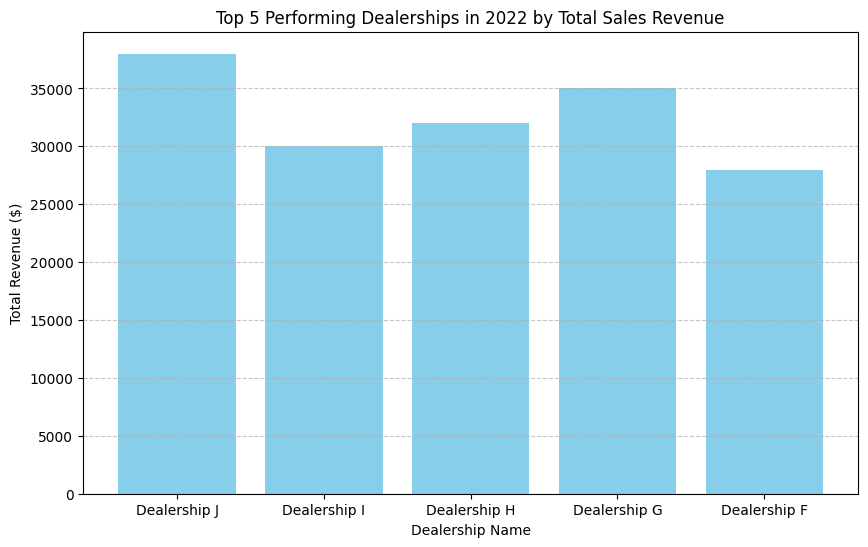


================================ Human Message =================================

What is the total sales revenue for the top 5 performing dealerships in the year 2022? Return the result in a table format with columns: Dealership Name, Total Revenue.
================================== Ai Message ==================================

This message is allowed. Continue.
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (ZjrU7kudY)
 Call ID: ZjrU7kudY
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Cars, Dealerships, Sales
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (nu04V2QDd)
 Call ID: nu04V2QDd
  Args:
    table_names: Dealerships, Sales
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Dealerships" (
	id INTEGER,

In [ ]:
user_input = "Write Python code to plot these results on a bar graph. Then, you must execute the code and show the bar graph."

messages.append(HumanMessage(content=user_input))

result = agent.graph.invoke({'messages': messages})

for message in result["messages"]:
    message.pretty_print()

memory_length = len(messages)

messages += result["messages"][memory_length:]

As expected, the agent successfully called the `python_repl` tool to generate and execute Python code, resulting in a graphical representation of the results. Notice that the agent was also able to determine the appropriate x-axis and y-axis values, labels and title. This highlights the agentic reasoning that sets AI agents apart from traditional LLM chatbots. 

To obtain a visual representation of the agent's graph, we can display the graph flow.

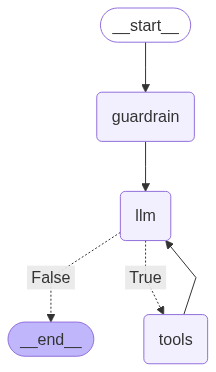

In [ ]:
display(Image(agent.graph.get_graph().draw_mermaid_png()))

## Summary 

In this tutorial, we explored how to build a text-to-SQL ReAct agent with LangGraph. Instead of using the prebuilt agent executor function, `create_react_agent`, we built our agent from scratch. After parsing a user's question in natural language, our artificial intelligence agent uses its tools for SQL query generation, validation and execution, demonstrating skill in both SQL and Python. Given the LangChain `PythonREPLTool` class integrated into a custom tool, the agent is equipped with the ability to not only generate but also execute Python code. We saw the successful execution of this tool upon prompting the agent for a graphical representation of its response. With this tutorial, we have exhibited the coding and multimodal reasoning capabilities of Mistral Medium 3. As a next step, consider experimenting with additional nodes and edges in the graph. Perhaps, try incorporating another agent with its own set of tools. One example of this is a supervisor agent that implements guardrails to prevent malicious database injections. 

#### Footnotes: 

<sup>1</sup> “Medium Is the New Large.” Mistral.ai, 7 May 2025, mistral.ai/news/mistral-medium-3.